In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
df = pd.read_csv('data/robust.csv')
df.set_index('Unnamed: 0', inplace=True)
df.rename_axis('Ticker', inplace=True)
df.head()

2022-07-18  2022-07-19  2022-07-20  2022-07-21  2022-07-22  \
Ticker                                                               
III.L          0.0   -0.650000   -0.602317    0.195004    0.459569   
ADM.L          0.0   -2.313636   -1.935650   -1.081386   -1.125337   
AAF.L          0.0    1.650000    0.870013    0.887994    0.489218   
ALW.L          0.0   -0.495455   -0.231660    0.146656   -0.039084   
AAL.L          0.0   -1.150000   -0.731017   -0.759065   -0.513477   

        2022-07-25  2022-07-26  2022-07-27  2022-07-28  2022-07-29  ...  \
Ticker                                                              ...   
III.L     0.056645   -0.058515   -0.100295    0.093202    0.224565  ...   
ADM.L    -1.363834   -0.748687   -0.053097    0.343202    0.527039  ...   
AAF.L     0.689906    1.669917    1.799410    0.207237   -0.847846  ...   
ALW.L     0.068264   -0.190548   -0.132743   -0.029605   -0.044913  ...   
AAL.L    -0.082789    0.880720    0.864307    1.044956    1.212649  ...   

        2024-12-10  2024-12-12  2024-12-13  2024-12-18  2024-12-19  \
Ticker                                                               
III.L     3.147712    3.117607    3.088897    2.931030    2.933371   
ADM.L     0.523053    0.494492    0.477556    0.447021    0.474877   
AAF.L    -0.906421   -0.904762   -0.891320   -0.822272   -0.837909   
ALW.L     0.293887    0.289104    0.284421    0.242912    0.254917   
AAL.L    -0.424522   -0.399424   -0.432960   -0.423045   -0.454763   

        2024-12-20  2024-12-23  2024-12-24  2024-12-27  2024-12-30  
Ticker                                                              
III.L     2.997321    2.999163    3.005385    2.983514    2.915837  
ADM.L     0.489786    0.497363    0.499710    0.487646    0.480748  
AAF.L    -0.860013   -0.834408   -0.804407   -0.766882   -0.737436  
ALW.L     0.277461    0.281373    0.270400    0.250254    0.257647  
AAL.L    -0.479069   -0.479782   -0.468395   -0.468433   -0.460437  

[5 rows x 613 columns]

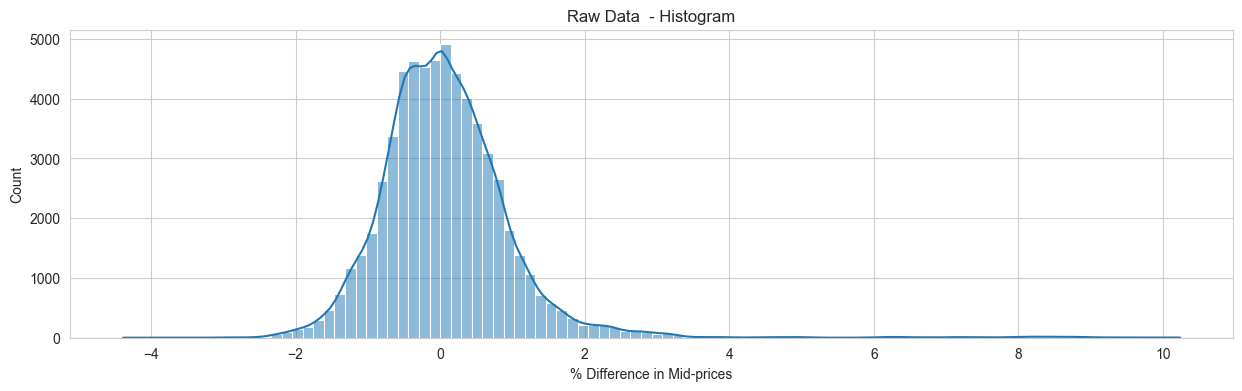

In [3]:
plt.figure(figsize=(15, 4))
sns.histplot(df.values.flatten(), bins=100, kde=True)
plt.title(f'{"Raw Data"}  - Histogram')
plt.xlabel("% Difference in Mid-prices")
plt.show()

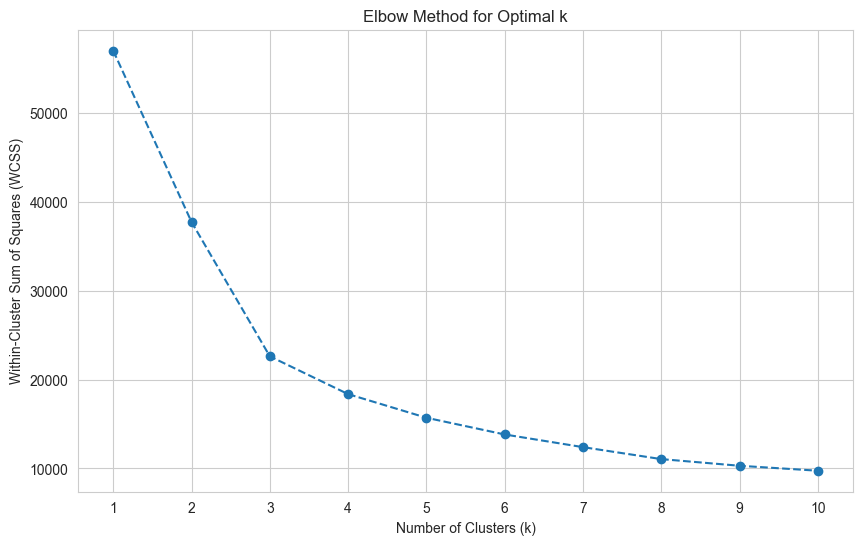

In [4]:
# Implement the Elbow Method
wcss = []  # Within-cluster sum of squares
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.grid(True)

In [7]:
# Choose optimal k based on the elbow (assume 4 here)
optimal_k = 5

# Fit clustering models
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(df)
gmm = GaussianMixture(n_components=optimal_k, random_state=42).fit(df)
dbscan = DBSCAN(eps=2.5, min_samples=3).fit(df)
agglo = AgglomerativeClustering(n_clusters=optimal_k).fit(df)
birch = Birch(n_clusters=optimal_k).fit(df)

# Step 5: Evaluation Metrics
def evaluate_clustering(data, labels, name):
    if len(set(labels)) <= 1:
        print(f"{name} clustering resulted in 1 or fewer clusters. Skipping metrics.\n")
        return
    print(f"Results for {name}:")
    print(f"Silhouette Score (Higher is better): {silhouette_score(data, labels):.3f}")
    print(f"Davies-Bouldin Index (Lower is better): {davies_bouldin_score(data, labels):.3f}")
    print(f"Calinski-Harabasz Score (Higher is better): {calinski_harabasz_score(data, labels):.3f}\n")

evaluate_clustering(df, kmeans.labels_, "KMeans")
evaluate_clustering(df, gmm.predict(df), "GMM")
evaluate_clustering(df, dbscan.labels_, "DBSCAN")
evaluate_clustering(df, agglo.labels_, "Agglomerative")
evaluate_clustering(df, birch.labels_, "Birch")

# # Step 6: Visualize stock trends by cluster
# def plot_clusters_trend(df, labels, title_prefix):
#     df_copy = df.copy()
#     df_copy['Cluster'] = labels
#     for cluster_id in sorted(df_copy['Cluster'].unique()):
#         cluster_members = df_copy[df_copy['Cluster'] == cluster_id].drop(columns='Cluster')
#         plt.figure(figsize=(14, 5))
#         for i in range(len(cluster_members)):
#             plt.plot(cluster_members.columns, cluster_members.iloc[i], alpha=0.4)
#         plt.title(f"{title_prefix} - Cluster {cluster_id} Trends")
#         plt.xticks([])
#         plt.tight_layout()
#         plt.show()

from matplotlib.ticker import MaxNLocator

# Step 6: Visualize stock trends by cluster
def plot_clusters_trend(df, labels, title_prefix, tick_interval=50):
    """
    Plots stock trends for each cluster with xticks shown at specified intervals.

    Parameters:
        df (pd.DataFrame): DataFrame of stock data with dates as columns.
        labels (array-like): Cluster labels for each row in df.
        title_prefix (str): Title prefix for each plot.
        tick_interval (int): Interval for x-axis ticks (default=5).
    """
    df_copy = df.copy()
    df_copy['Cluster'] = labels
    
    for cluster_id in sorted(df_copy['Cluster'].unique()):
        cluster_members = df_copy[df_copy['Cluster'] == cluster_id].drop(columns='Cluster')
        plt.figure(figsize=(14, 5))
        
        for i in range(len(cluster_members)):
            plt.plot(cluster_members.columns, cluster_members.iloc[i], alpha=0.4)
        
        plt.title(f"{title_prefix} - Cluster {cluster_id} Trends")
        plt.xlabel('Date')
        
        # Set xtick intervals
        ax = plt.gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune=None, nbins='auto'))
        xticks = range(0, len(cluster_members.columns), tick_interval)
        plt.xticks(xticks, [cluster_members.columns[i] for i in xticks], rotation=45)
        
        plt.tight_layout()
        plt.show()

Results for KMeans:
Silhouette Score (Higher is better): 0.201
Davies-Bouldin Index (Lower is better): 1.161
Calinski-Harabasz Score (Higher is better): 59.344

Results for GMM:
Silhouette Score (Higher is better): 0.201
Davies-Bouldin Index (Lower is better): 1.161
Calinski-Harabasz Score (Higher is better): 59.344

DBSCAN clustering resulted in 1 or fewer clusters. Skipping metrics.

Results for Agglomerative:
Silhouette Score (Higher is better): 0.194
Davies-Bouldin Index (Lower is better): 1.050
Calinski-Harabasz Score (Higher is better): 56.616

Results for Birch:
Silhouette Score (Higher is better): 0.194
Davies-Bouldin Index (Lower is better): 1.050
Calinski-Harabasz Score (Higher is better): 56.616



# KMeans

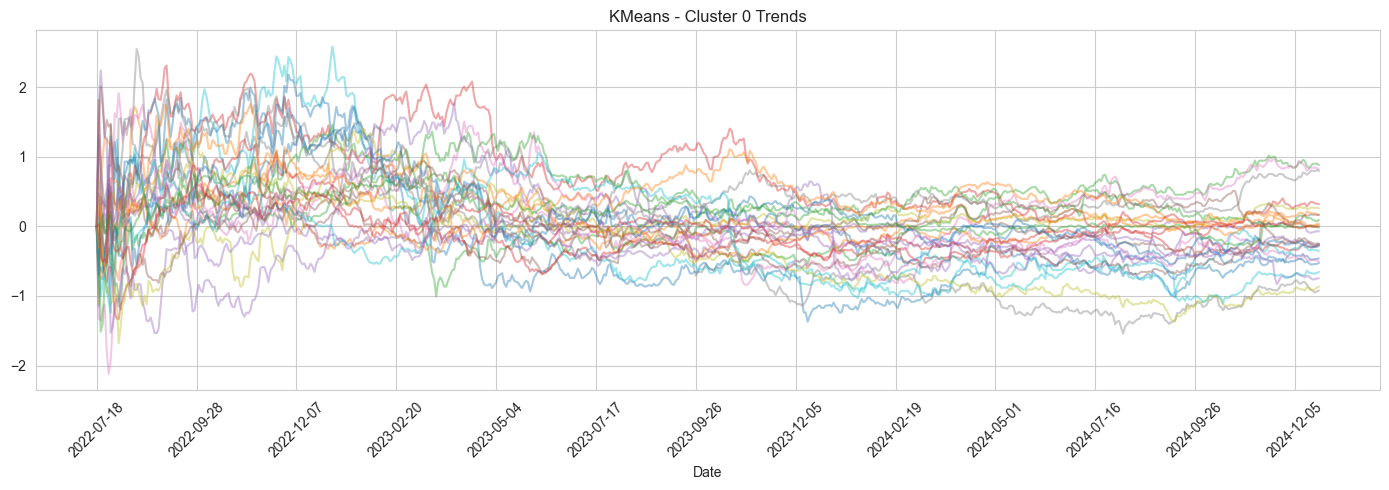

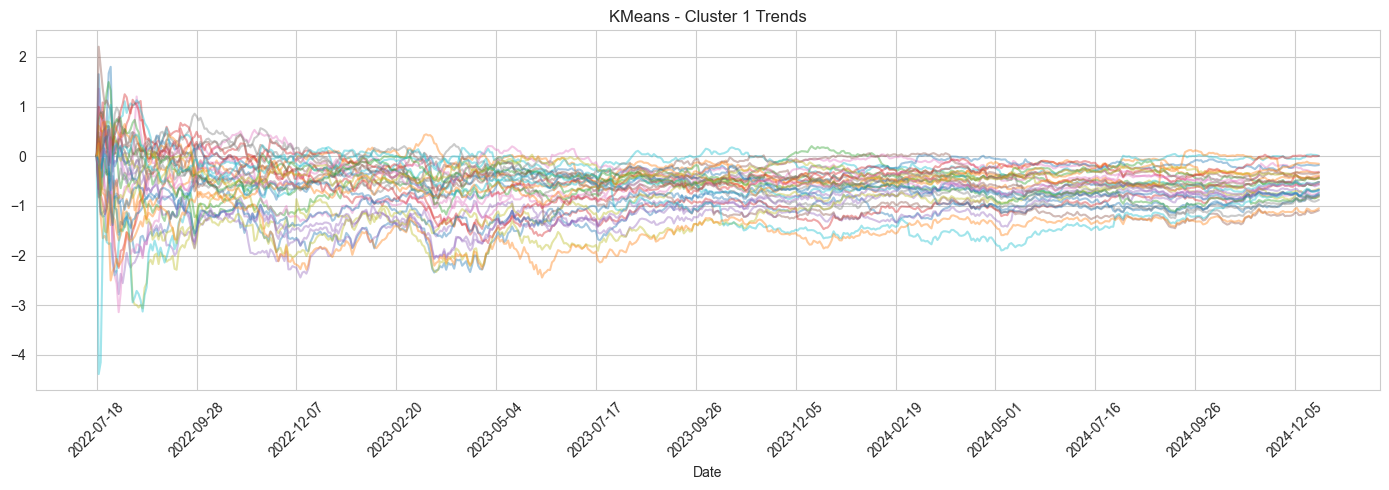

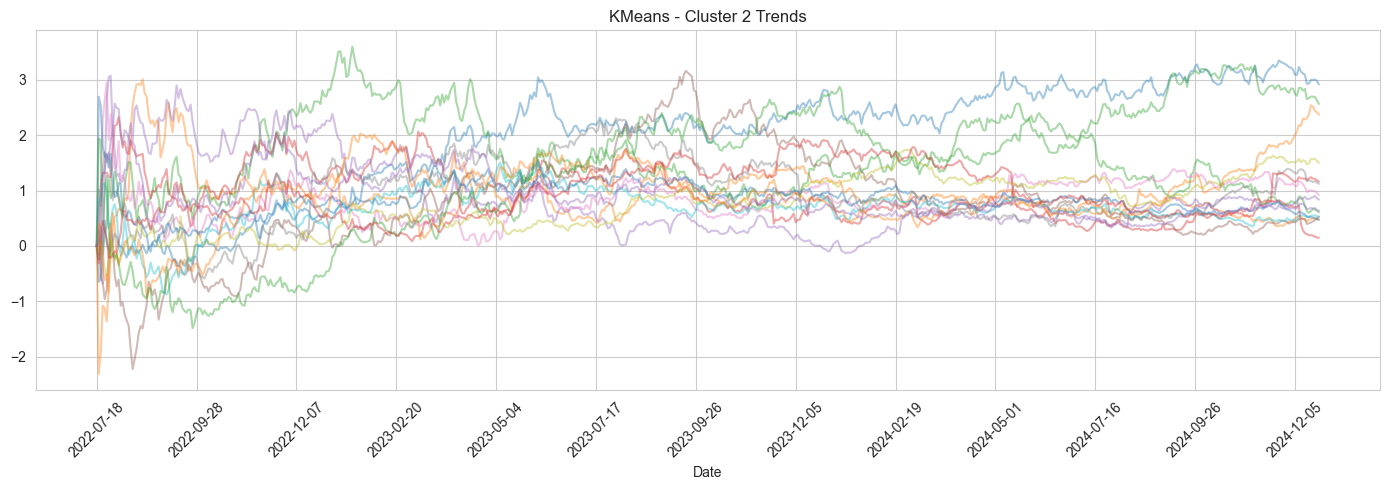

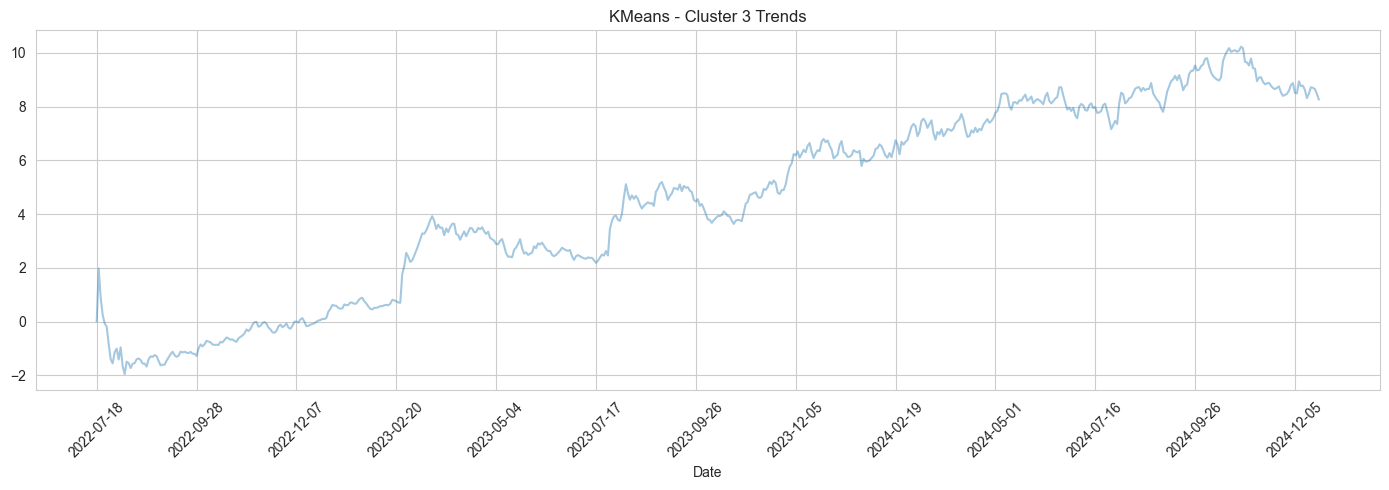

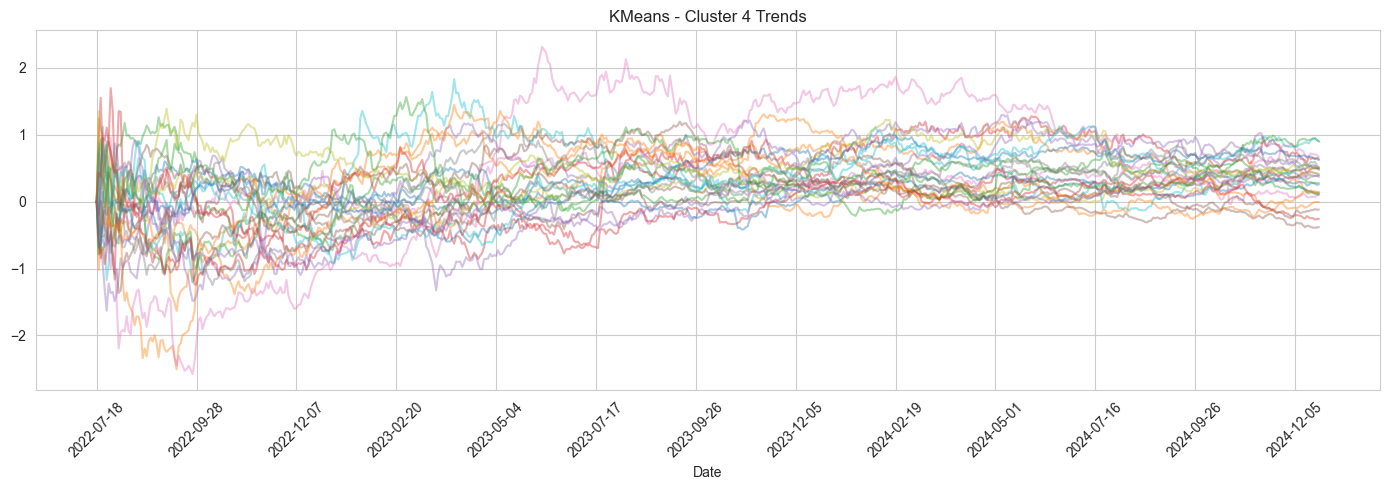

In [8]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df, kmeans.labels_, "KMeans")

# Agglomerative

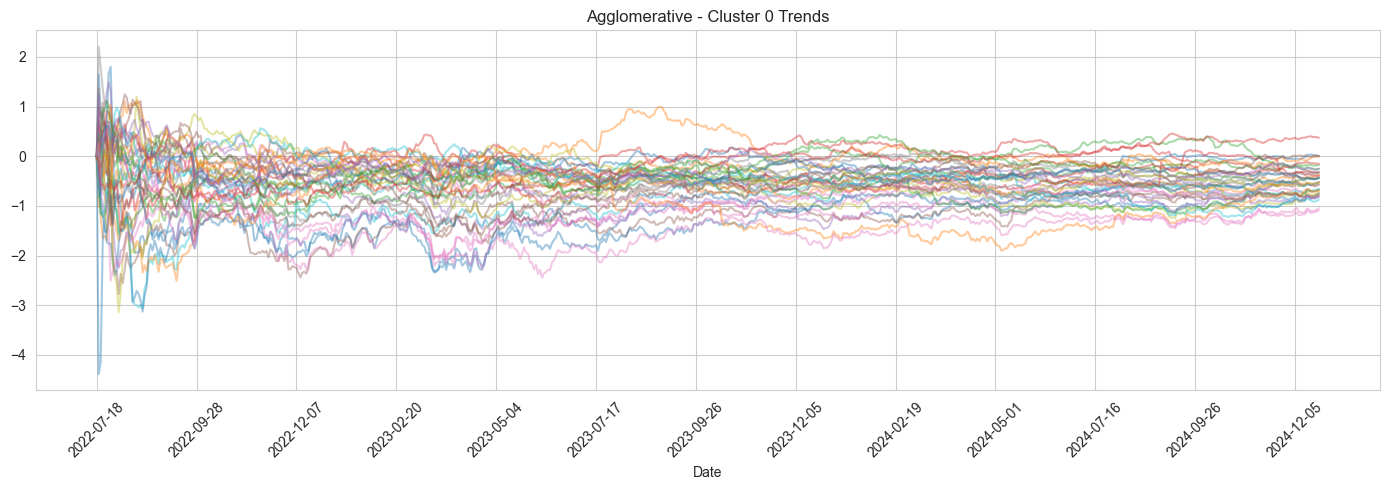

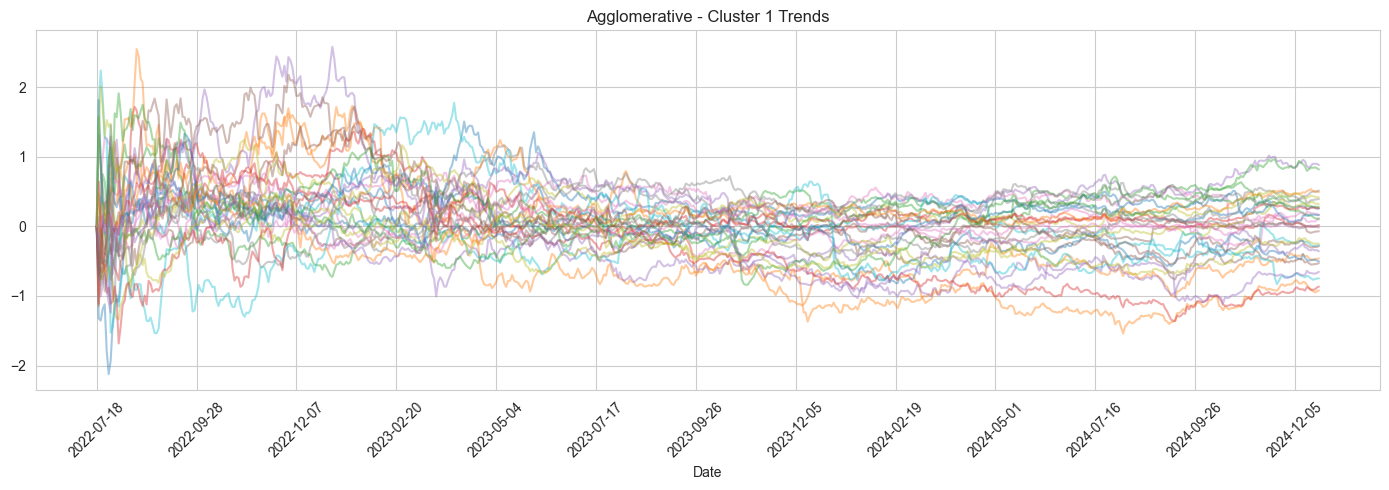

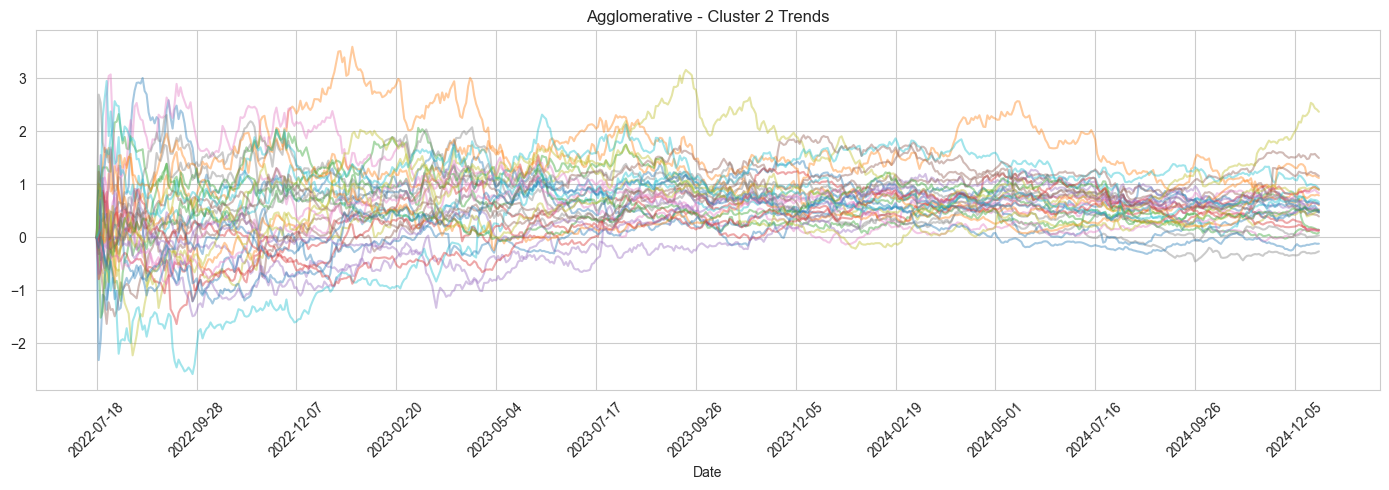

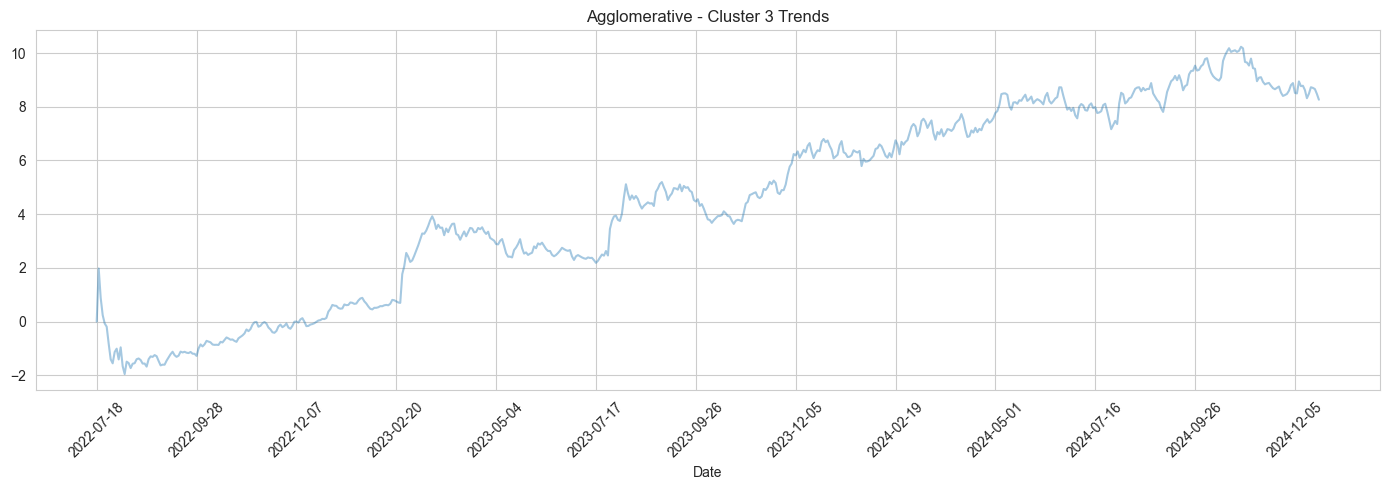

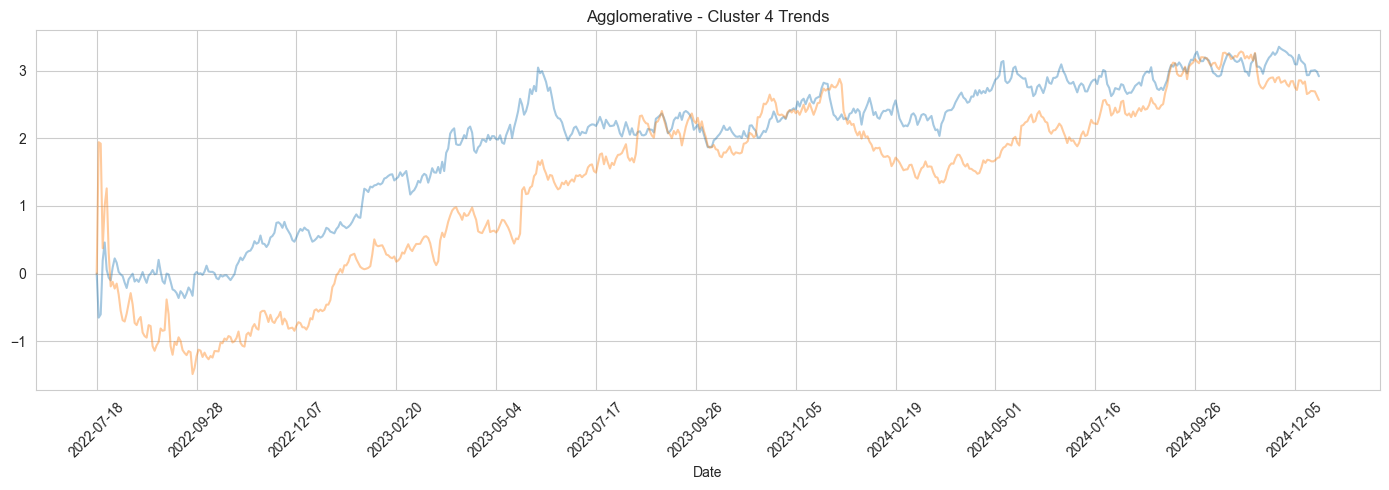

In [9]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df, agglo.labels_, "Agglomerative")

# GMM

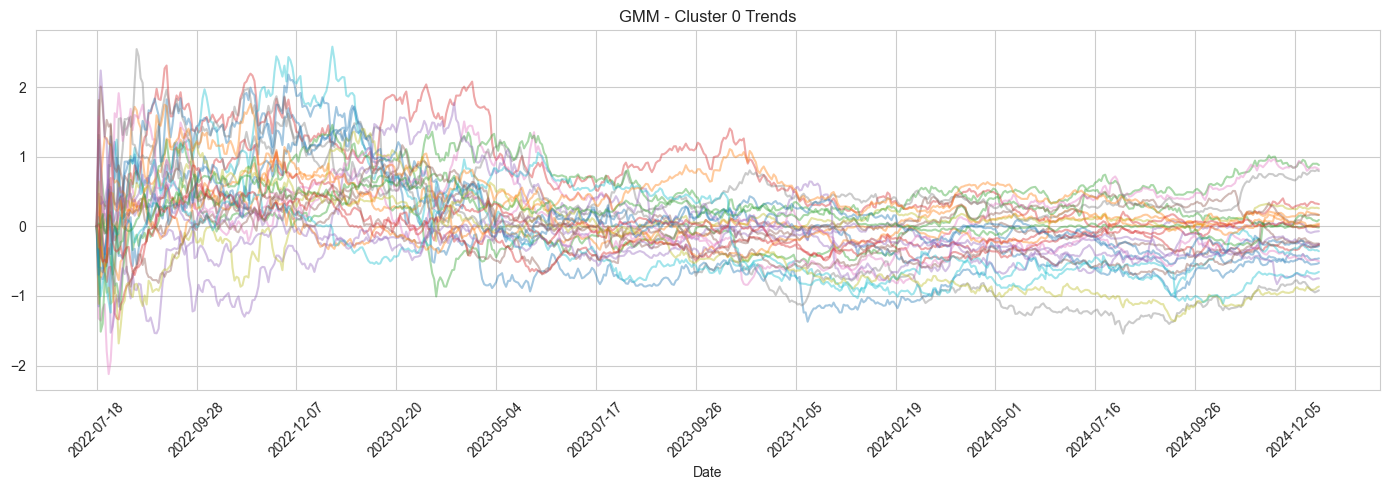

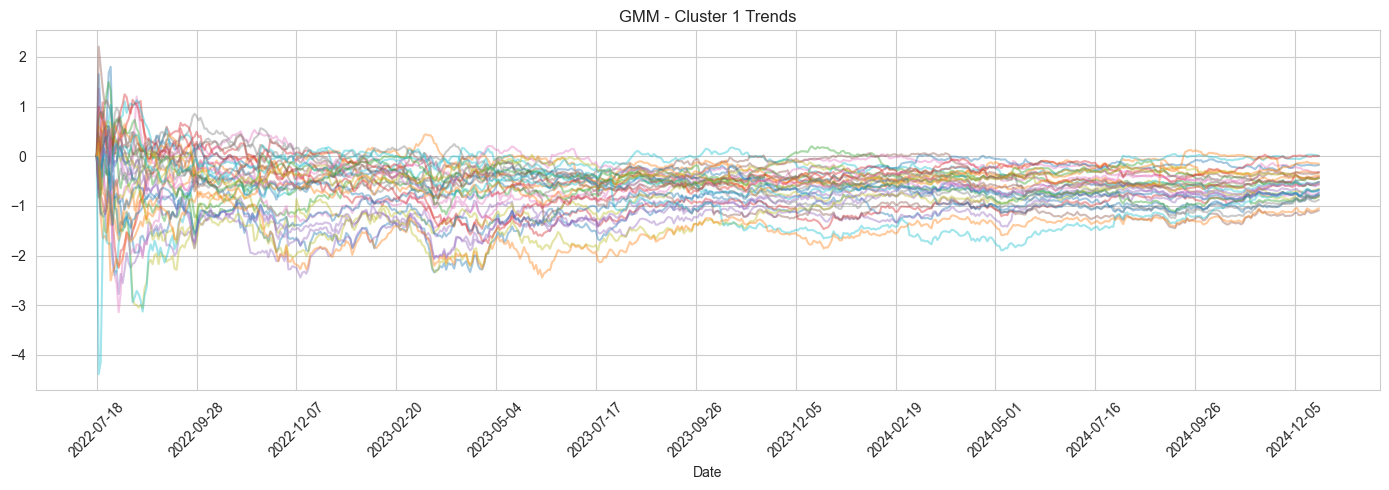

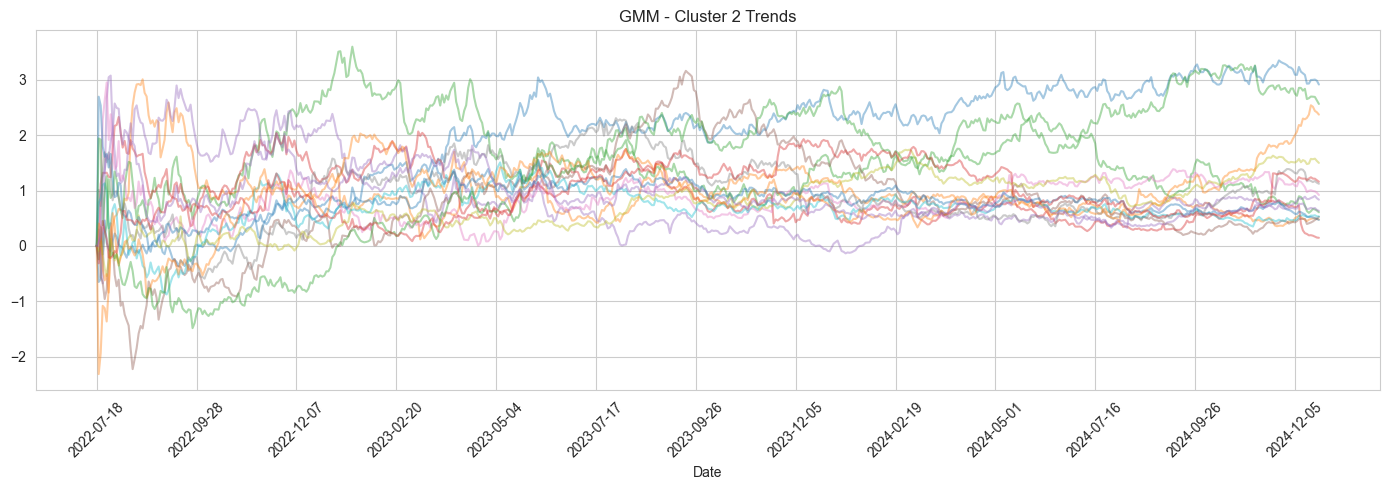

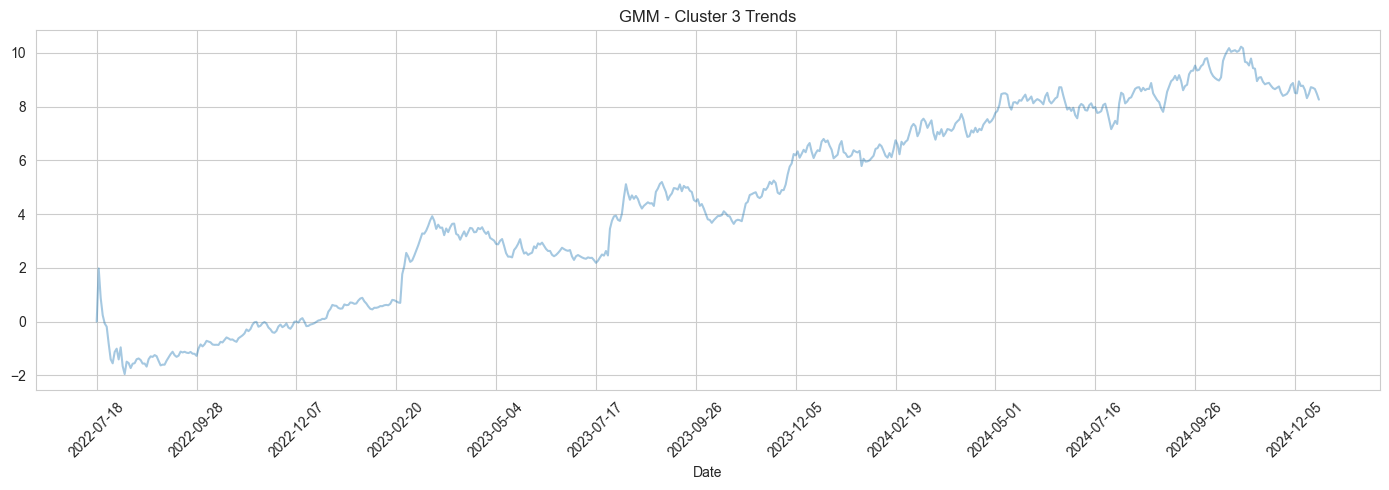

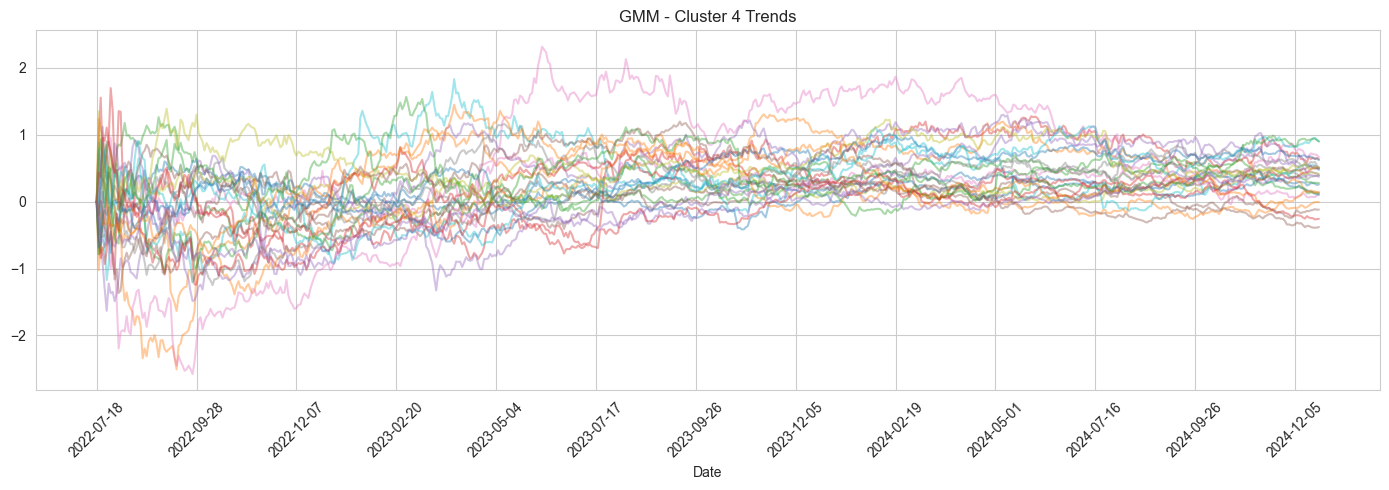

In [10]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df, gmm.predict(df), "GMM")

# Birch

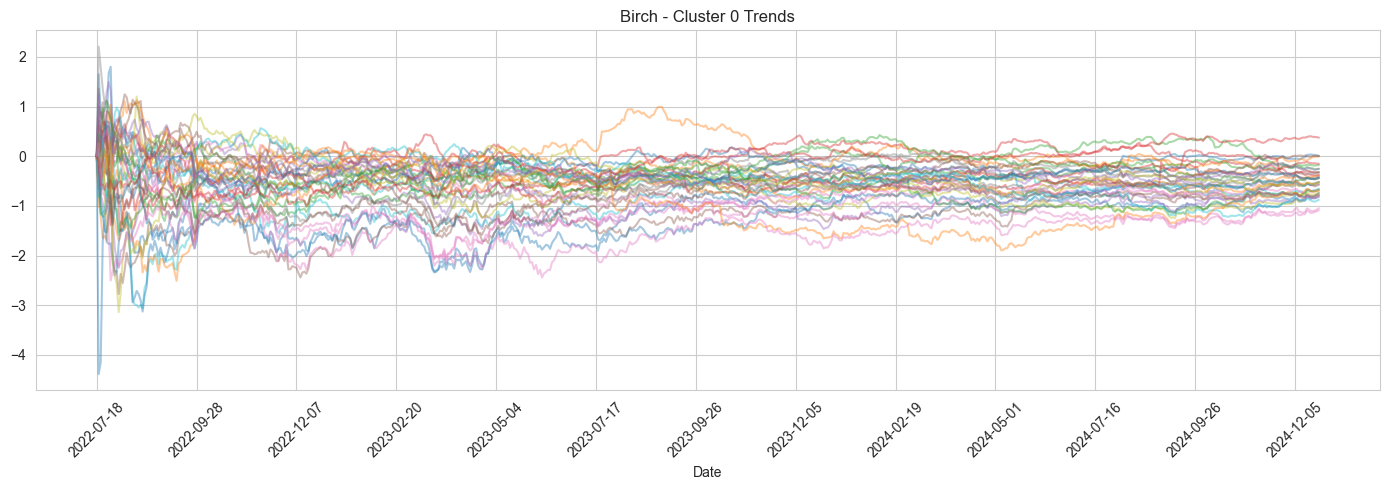

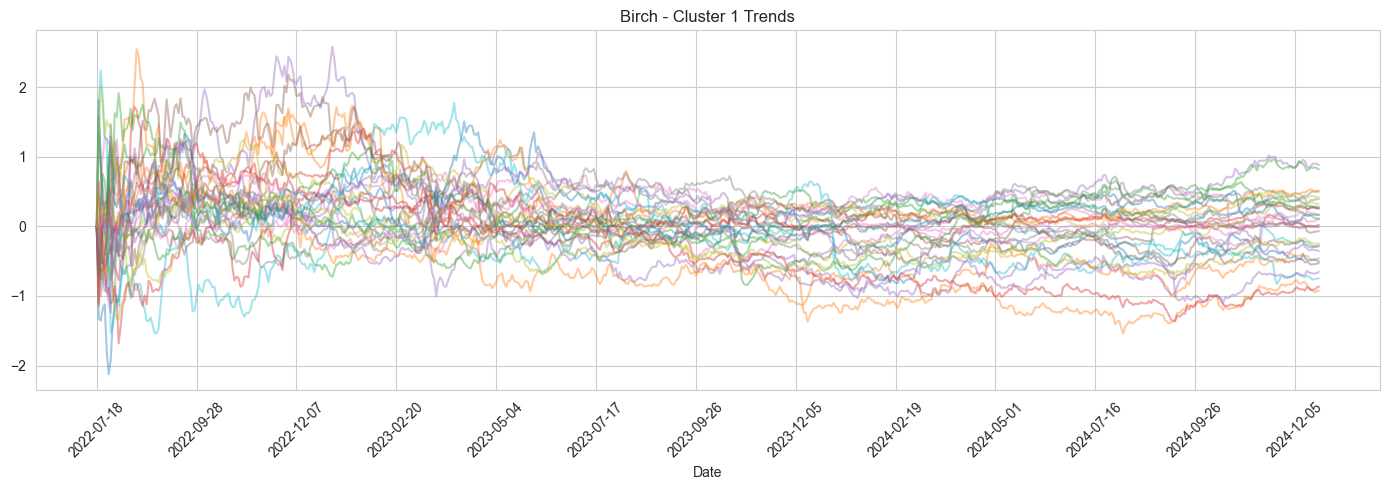

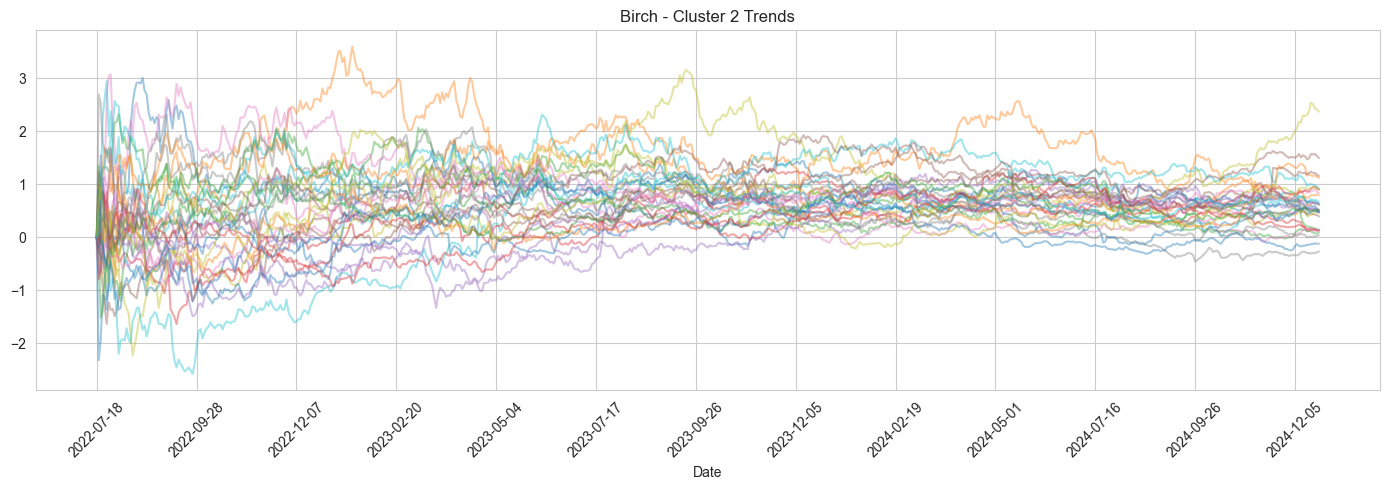

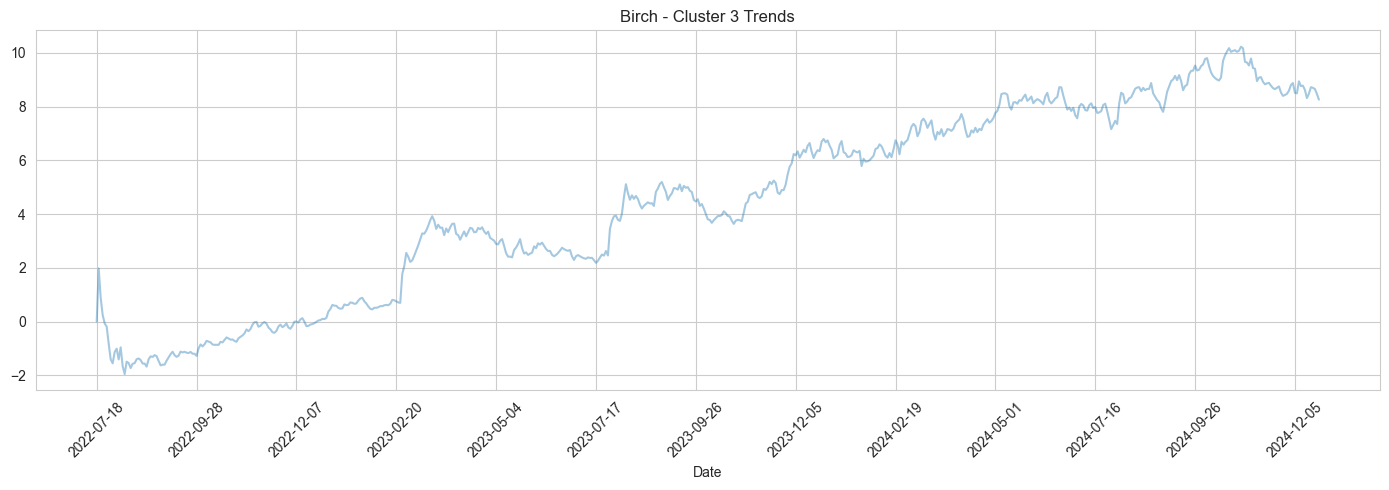

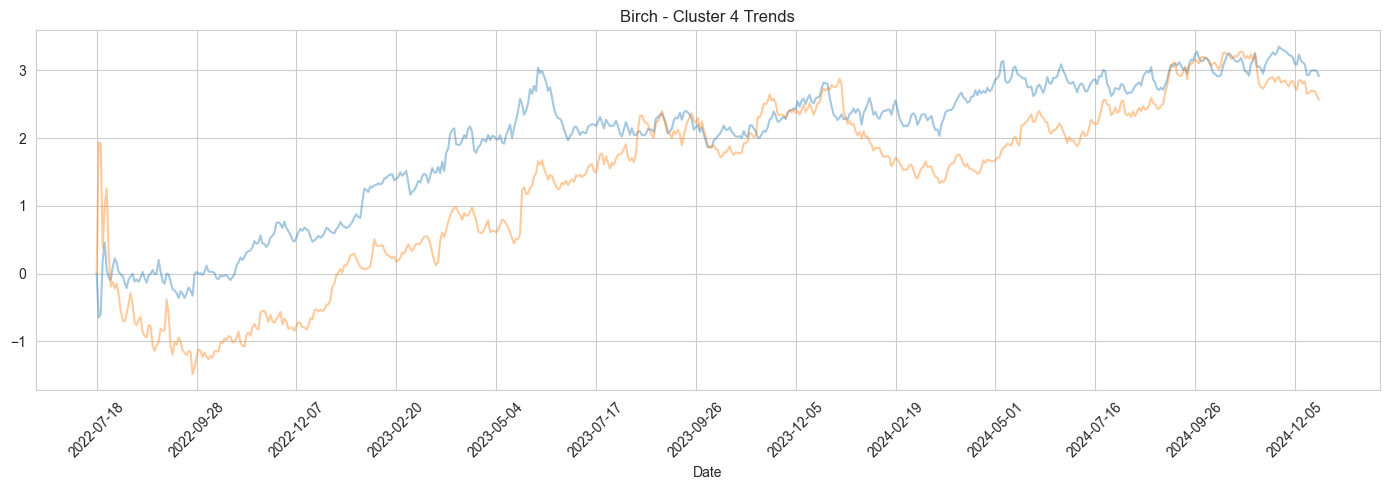

In [11]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df, birch.labels_, "Birch")

In [12]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df)

umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(df)

def plot_clusters_2D(X_proj, labels, method_name, reduction="t-SNE"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=labels, palette='tab10', s=30)
    plt.title(f'{method_name} Clusters Visualized with {reduction}')
    plt.grid(True)
    plt.show()

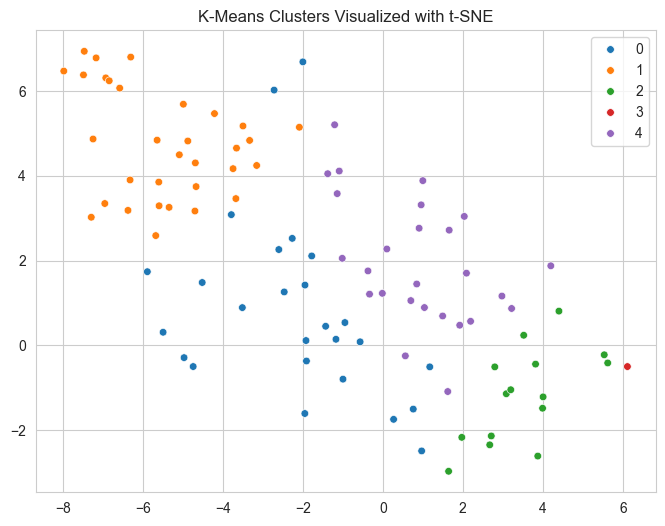

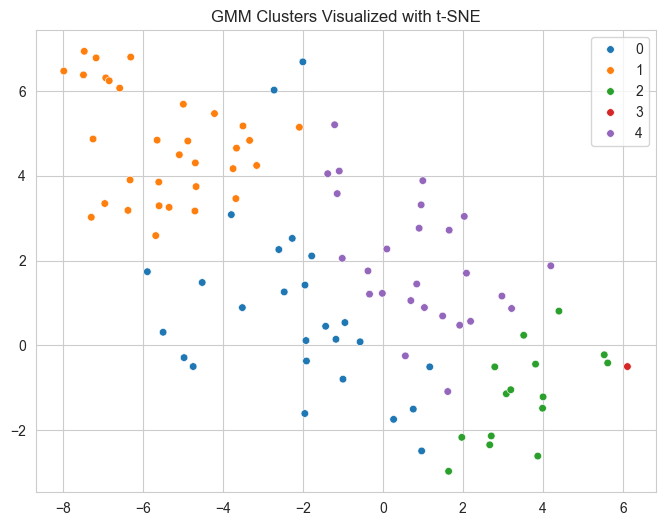

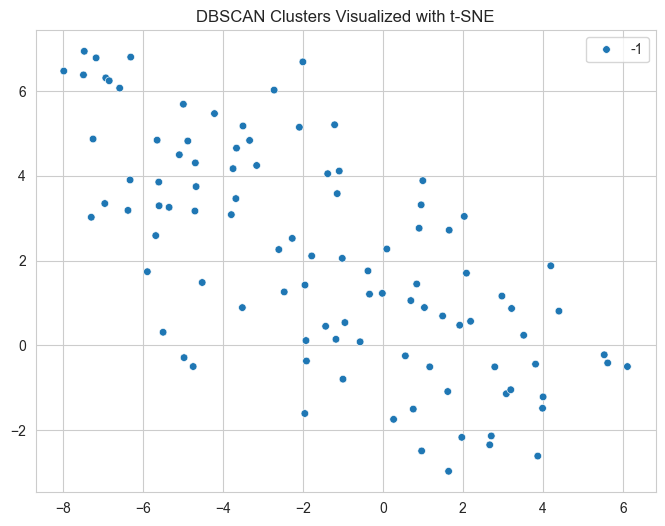

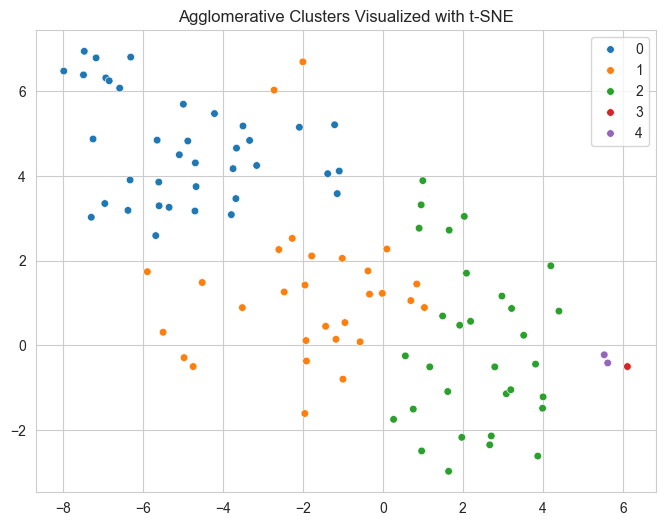

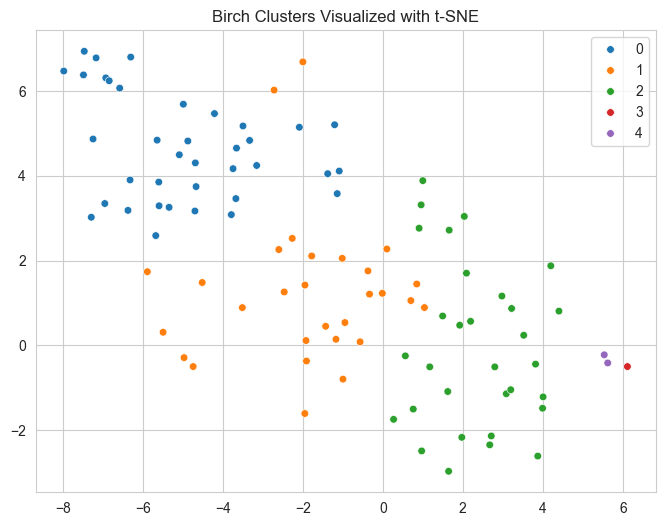

In [13]:
plot_clusters_2D(X_tsne, kmeans.labels_, "K-Means", "t-SNE")
plot_clusters_2D(X_tsne, gmm.predict(df), "GMM", "t-SNE")
plot_clusters_2D(X_tsne, dbscan.labels_, "DBSCAN", "t-SNE")
plot_clusters_2D(X_tsne, agglo.labels_, "Agglomerative", "t-SNE")
plot_clusters_2D(X_tsne, birch.labels_, "Birch", "t-SNE")

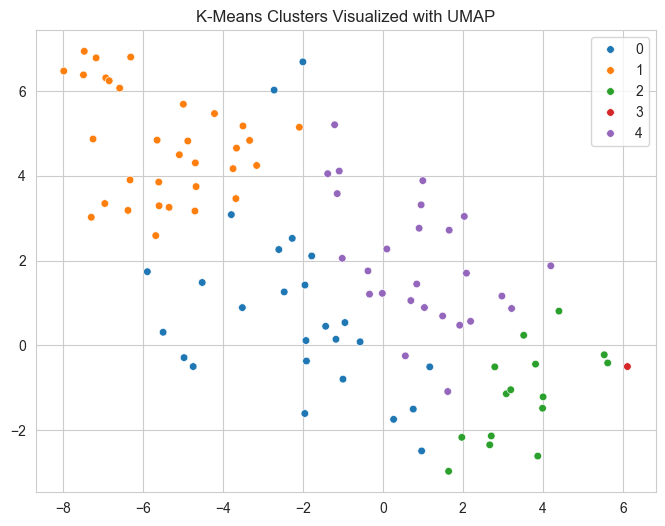

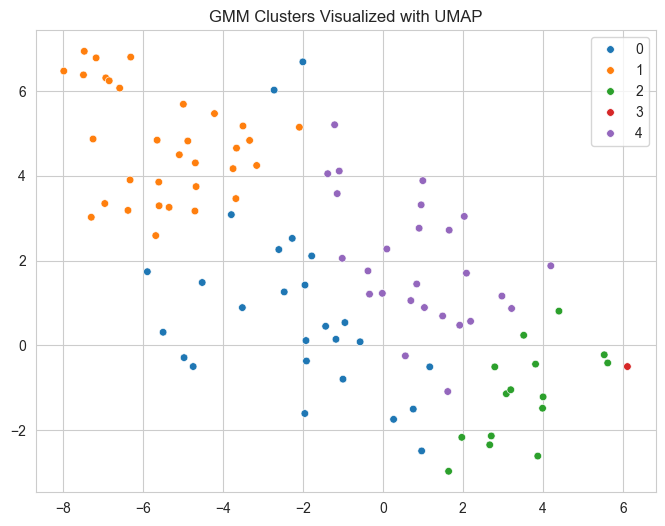

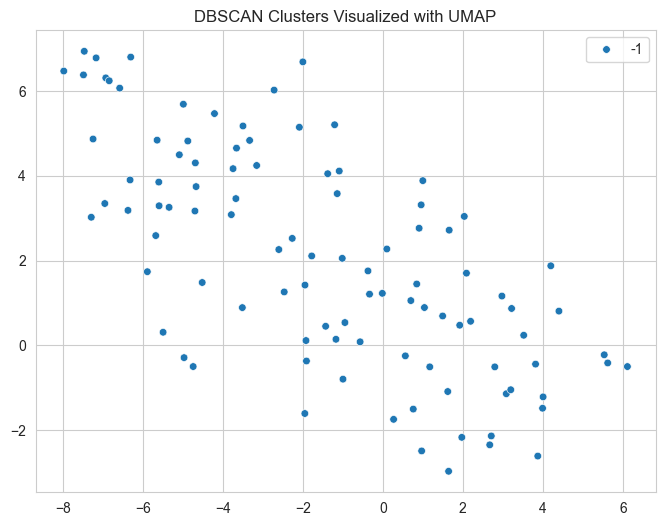

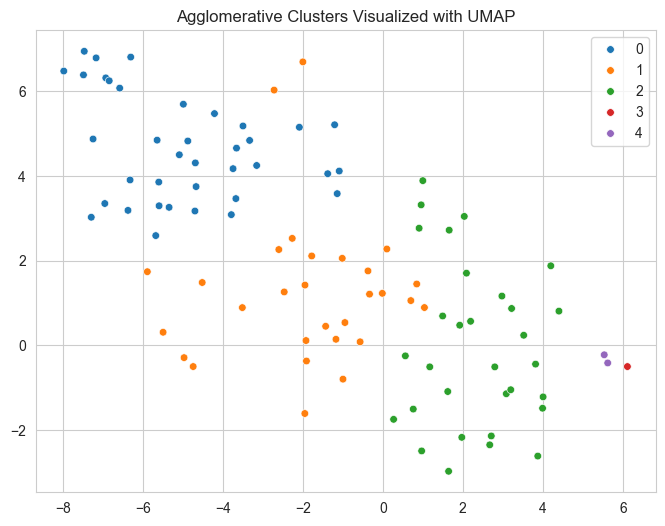

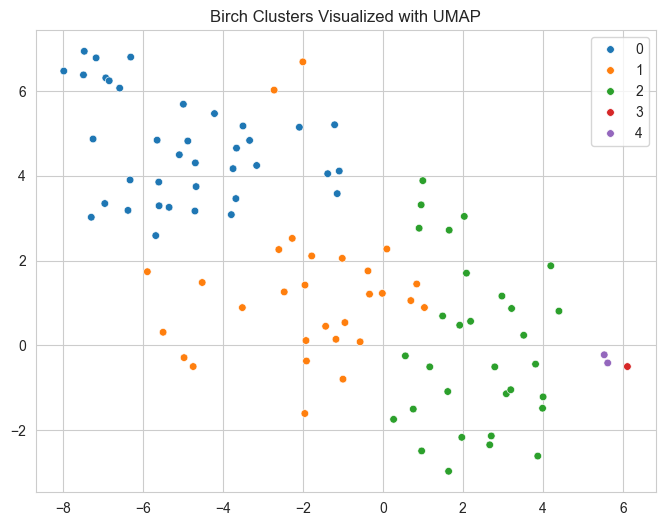

In [14]:
plot_clusters_2D(X_tsne, kmeans.labels_, "K-Means", "UMAP")
plot_clusters_2D(X_tsne, gmm.predict(df), "GMM", "UMAP")
plot_clusters_2D(X_tsne, dbscan.labels_, "DBSCAN", "UMAP")
plot_clusters_2D(X_tsne, agglo.labels_, "Agglomerative", "UMAP")
plot_clusters_2D(X_tsne, birch.labels_, "Birch", "UMAP")